<a href="https://colab.research.google.com/github/aliiabedii/Transformers/blob/main/Ali_paper_replicate_4D_equally_distributed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12 or int(torch.__version__.split(".")[0]) == 2, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

torch version: 2.1.0+cu121
torchvision version: 0.16.0+cu121


In [2]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4056, done.
remote: Counting objects: 100% (4056/4056), done.
remote: Compressing objects: 100% (1626/1626), done.
remote: Total 4056 (delta 2387), reused 3946 (delta 2369), pack-reused 0
Receiving objects: 100% (4056/4056), 649.87 MiB | 34.98 MiB/s, done.
Resolving deltas: 100% (2387/2387), done.
Updating files: 100% (248/248), done.


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')


Mounted at /content/drive


# download dataset from kaggle (remember to download the API token first)

In [4]:
pip install opendatasets

In [6]:
import opendatasets as od
# import pandas

# od.download(
# 	"https://www.kaggle.com/datasets/aliiabedii/shmcompitionv2/download?datasetVersionNumber=1")

od.download(
    "https://www.kaggle.com/datasets/aliiabedii/ichgm-tiff/download?datasetVersionNumber=1")

100%|██████████| 180M/180M [00:01<00:00, 114MB/s]


# equally split folder into training and validation

In [7]:
pip install split-folders[full]

In [8]:
import splitfolders
splitfolders.ratio('/content/ichgm-tiff/dataTIFF', output="splited", seed=1337, ratio=(.8, 0.2))

Copying files: 3500 files [00:04, 850.84 files/s]


# creat dataloader and visualize it

In [17]:
import os
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image

class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.class_folders = [folder for folder in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, folder))]
        self.class_to_index = {cls: i for i, cls in enumerate(self.class_folders)}
        self.file_list = self._create_file_list()

    def _create_file_list(self):
        file_list = []
        for class_folder in self.class_folders:
            class_path = os.path.join(self.root_dir, class_folder)
            class_files = [os.path.join(class_folder, file) for file in os.listdir(class_path)]
            file_list.extend(class_files)
        return file_list

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        # Load TIFF image
        image_path = os.path.join(self.root_dir, self.file_list[idx])
        image = Image.open(image_path)

        # Extract class label from the folder structure
        class_folder = os.path.dirname(self.file_list[idx])
        class_label = self.class_to_index[class_folder]

        # Apply transformations if specified
        if self.transform:
            image = self.transform(image)

        return image, class_label

# Define the data transformation
data_transform = transforms.Compose([
    transforms.ToTensor(),  # Converts PIL Image to PyTorch tensor
])

# Specify the path to your root folder containing class folders
train_dataset = "/content/splited/train"
test_dataset = "/content/splited/val"

# Create the custom dataset
custom_dataset_train = CustomDataset(root_dir=train_dataset, transform=data_transform)
custom_dataset_test = CustomDataset(root_dir=test_dataset, transform=data_transform)


# # Split the dataset into training and validation sets
# train_size = int(0.8 * len(custom_dataset))
# val_size = len(custom_dataset) - train_size
# train_dataset, val_dataset = random_split(custom_dataset, [train_size, val_size])


# Create data loaders for training and validation sets
batch_size = 24
train_loader = DataLoader(custom_dataset_train, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(custom_dataset_test, batch_size=batch_size, shuffle=True)

# Example of how to iterate through the data loaders
for images, labels in train_loader:
    # Access the batch of images and labels for training
    print("Training Batch:")
    print(images.shape)  # This will be (batch_size, channels, height, width)
    print(labels)  # Batch of class labels
    break

for images, labels in val_loader:
    # Access the batch of images and labels for validation
    print("Validation Batch:")
    print(images.shape)  # This will be (batch_size, channels, height, width)
    print(labels)  # Batch of class labels
    break


Training Batch:
torch.Size([24, 4, 224, 224])
tensor([2, 6, 3, 4, 3, 2, 1, 4, 0, 3, 4, 5, 0, 1, 0, 4, 5, 4, 5, 3, 6, 1, 4, 0])
Validation Batch:
torch.Size([24, 4, 224, 224])
tensor([1, 3, 5, 0, 2, 3, 4, 3, 0, 1, 4, 5, 4, 2, 4, 2, 1, 2, 4, 1, 4, 4, 6, 1])


# older dataloader

In [ ]:
import os
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image

class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.class_folders = [folder for folder in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, folder))]
        self.class_to_index = {cls: i for i, cls in enumerate(self.class_folders)}
        self.file_list = self._create_file_list()

    def _create_file_list(self):
        file_list = []
        for class_folder in self.class_folders:
            class_path = os.path.join(self.root_dir, class_folder)
            class_files = [os.path.join(class_folder, file) for file in os.listdir(class_path)]
            file_list.extend(class_files)
        return file_list

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        # Load TIFF image
        image_path = os.path.join(self.root_dir, self.file_list[idx])
        image = Image.open(image_path)

        # Extract class label from the folder structure
        class_folder = os.path.dirname(self.file_list[idx])
        class_label = self.class_to_index[class_folder]

        # Apply transformations if specified
        if self.transform:
            image = self.transform(image)

        return image, class_label

# Define the data transformation
data_transform = transforms.Compose([
    transforms.ToTensor(),  # Converts PIL Image to PyTorch tensor
])

# Specify the path to your root folder containing class folders
root_data_path = "/content/drive/MyDrive/dataTIFF"

# Create the custom dataset
custom_dataset = CustomDataset(root_dir=root_data_path, transform=data_transform)

# Split the dataset into training and validation sets
train_size = int(0.8 * len(custom_dataset))
val_size = len(custom_dataset) - train_size
train_dataset, val_dataset = random_split(custom_dataset, [train_size, val_size])


# Create data loaders for training and validation sets
batch_size = 18
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Example of how to iterate through the data loaders
for images, labels in train_loader:
    # Access the batch of images and labels for training
    print("Training Batch:")
    print(images.shape)  # This will be (batch_size, channels, height, width)
    print(labels)  # Batch of class labels
    break

for images, labels in val_loader:
    # Access the batch of images and labels for validation
    print("Validation Batch:")
    print(images.shape)  # This will be (batch_size, channels, height, width)
    print(labels)  # Batch of class labels
    break


Training Batch:
torch.Size([18, 4, 224, 224])
tensor([3, 1, 3, 0, 6, 2, 2, 3, 0, 3, 2, 2, 3, 4, 4, 0, 3, 3])
Validation Batch:
torch.Size([18, 4, 224, 224])
tensor([4, 5, 3, 0, 5, 4, 1, 0, 2, 4, 6, 1, 4, 3, 2, 4, 2, 6])


# Data visualization

torch.Size([4, 224, 224])
tensor(1)
Number of training samples: 22
Number of validation samples: 20


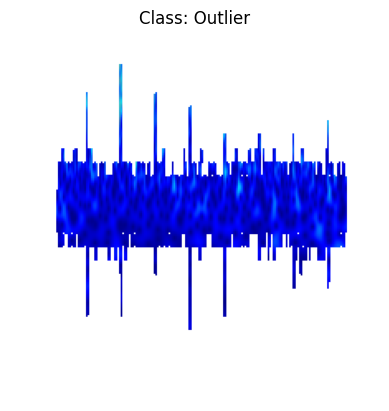

['Normal', 'Outlier', 'Missing', 'Minor', 'Drift', 'Square', 'Trend']

In [21]:
import numpy as np
# Load a sample batch (just one image in this case)
batch = next(iter(train_loader))
image, label = batch

# Convert the tensor back to a numpy array
image_np = np.transpose(image[0].squeeze().numpy(), (1, 2, 0))

# Get a single image from the batch
image, label = image[0], label[0]

# View the batch shapes

print(image.shape)
print(label)

# Print the number of samples in training and validation sets
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(test_dataset)}")

# Visualize the image without axis labels and ticks
plt.imshow(image_np)
plt.title(f"Class: {custom_dataset_train.class_folders[label.item()]}")  # Use class names instead of numerical labels
plt.axis('off')  # Turn off axis labels and ticks
plt.show()
custom_dataset_train.class_folders

Classes and Corresponding Indices:
Class: Normal, Index: 0
Class: Outlier, Index: 1
Class: Missing, Index: 2
Class: Minor, Index: 3
Class: Drift, Index: 4
Class: Square, Index: 5
Class: Trend, Index: 6


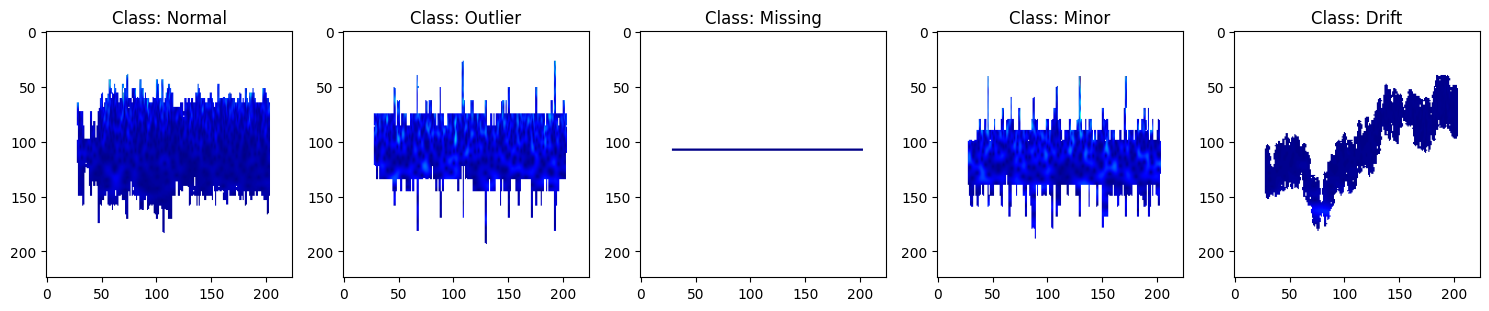

In [26]:
import random


# Get the class folders and corresponding indices
class_folders = custom_dataset_train.class_folders
class_to_index = custom_dataset_train.class_to_index

# Display the classes and corresponding indices
print("Classes and Corresponding Indices:")
for cls, idx in class_to_index.items():
    print(f"Class: {cls}, Index: {idx}")

# Select a sample image from each class and visualize
num_classes_to_display = min(len(class_folders), 5)  # Display up to 5 classes
fig, axs = plt.subplots(1, num_classes_to_display, figsize=(15, 3))

for i in range(num_classes_to_display):
    # Get a random sample from the class
    class_folder = class_folders[i]
    class_idx = class_to_index[class_folder]
    class_samples = [idx for idx, label in enumerate(custom_dataset_train) if label[1] == class_idx]
    random_sample_idx = random.choice(class_samples)
    sample_image, _ = custom_dataset_train[random_sample_idx]
    # sample_image=sample_image[:3,:,:]
    # Plot the sample image
    axs[i].imshow(sample_image.permute(1, 2, 0))
    axs[i].set_title(f"Class: {class_folder}")

plt.tight_layout()
plt.show()

# show bathes

In [27]:
# Iterate through the data loader and print the shape of each batch
for batch_idx, (images, labels) in enumerate(train_loader):
    print(f"Batch {batch_idx + 1}:")
    print(f"  Images shape: {images.shape}")  # Shape of the batch of images
    print(f"  Labels: {labels}")  # Batch of class labels


Batch 1:
  Images shape: torch.Size([24, 4, 224, 224])
  Labels: tensor([1, 5, 5, 2, 0, 0, 3, 4, 5, 2, 6, 5, 2, 5, 6, 0, 4, 0, 0, 2, 4, 5, 1, 3])
Batch 2:
  Images shape: torch.Size([24, 4, 224, 224])
  Labels: tensor([3, 5, 1, 3, 6, 4, 3, 1, 5, 4, 4, 6, 4, 2, 0, 5, 2, 4, 0, 4, 1, 4, 1, 4])
Batch 3:
  Images shape: torch.Size([24, 4, 224, 224])
  Labels: tensor([4, 3, 6, 2, 4, 4, 6, 2, 1, 5, 2, 6, 6, 0, 3, 6, 5, 5, 4, 3, 4, 0, 0, 1])
Batch 4:
  Images shape: torch.Size([24, 4, 224, 224])
  Labels: tensor([2, 3, 6, 6, 4, 2, 2, 2, 1, 0, 1, 5, 5, 6, 3, 6, 0, 3, 5, 4, 4, 3, 0, 0])
Batch 5:
  Images shape: torch.Size([24, 4, 224, 224])
  Labels: tensor([6, 4, 2, 6, 0, 2, 0, 6, 0, 6, 3, 6, 5, 1, 6, 0, 0, 3, 4, 0, 0, 0, 6, 3])
Batch 6:
  Images shape: torch.Size([24, 4, 224, 224])
  Labels: tensor([0, 6, 3, 5, 3, 3, 3, 4, 4, 1, 6, 4, 1, 2, 6, 0, 6, 0, 2, 6, 4, 0, 3, 1])
Batch 7:
  Images shape: torch.Size([24, 4, 224, 224])
  Labels: tensor([6, 3, 3, 4, 2, 1, 2, 0, 3, 5, 3, 4, 4, 6, 2, 1, 5, 

# define the functions

In [28]:
# 1. Create a class which subclasses nn.Module
class PatchEmbedding(nn.Module):
    """Turns a 2D input image into a 1D sequence learnable embedding vector.

    Args:
        in_channels (int): Number of color channels for the input images. Defaults to 3.
        patch_size (int): Size of patches to convert input image into. Defaults to 16.
        embedding_dim (int): Size of embedding to turn image into. Defaults to 768.
    """
    # 2. Initialize the class with appropriate variables
    def __init__(self,
                 in_channels:int=4,
                 patch_size:int=16,
                 embedding_dim:int=1024):
        super().__init__()

        # 3. Create a layer to turn an image into patches
        self.patcher = nn.Conv2d(in_channels=in_channels,
                                 out_channels=embedding_dim,
                                 kernel_size=patch_size,
                                 stride=patch_size,
                                 padding=0)

        # 4. Create a layer to flatten the patch feature maps into a single dimension
        self.flatten = nn.Flatten(start_dim=2, # only flatten the feature map dimensions into a single vector
                                  end_dim=3)

    # 5. Define the forward method
    def forward(self, x):
        # Create assertion to check that inputs are the correct shape
        image_resolution = x.shape[-1]
        assert image_resolution % patch_size == 0, f"Input image size must be divisble by patch size, image shape: {image_resolution}, patch size: {patch_size}"

        # Perform the forward pass
        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched)
        # 6. Make sure the output shape has the right order
        return x_flattened.permute(0, 2, 1) # adjust so the embedding is on the final dimension [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]

In [29]:
# 1. Create a class that inherits from nn.Module
class MultiheadSelfAttentionBlock(nn.Module):
    """Creates a multi-head self-attention block ("MSA block" for short).
    """
    # 2. Initialize the class with hyperparameters from Table 1
    def __init__(self,
                 embedding_dim:int=1024, # Hidden size D from Table 1 for ViT-Base
                 num_heads:int=2, # Heads from Table 1 for ViT-Base
                 attn_dropout:float=0): # doesn't look like the paper uses any dropout in MSABlocks
        super().__init__()

        # 3. Create the Norm layer (LN)
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

        # 4. Create the Multi-Head Attention (MSA) layer
        self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                    num_heads=num_heads,
                                                    dropout=attn_dropout,
                                                    batch_first=True) # does our batch dimension come first?

    # 5. Create a forward() method to pass the data throguh the layers
    def forward(self, x):
        x = self.layer_norm(x)
        attn_output, _ = self.multihead_attn(query=x, # query embeddings
                                             key=x, # key embeddings
                                             value=x, # value embeddings
                                             need_weights=False) # do we need the weights or just the layer outputs?
        return attn_output

In [30]:
# 1. Create a class that inherits from nn.Module
class MLPBlock(nn.Module):
    """Creates a layer normalized multilayer perceptron block ("MLP block" for short)."""
    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 embedding_dim:int=1024, # Hidden Size D from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 dropout:float=0.1): # Dropout from Table 3 for ViT-Base
        super().__init__()

        # 3. Create the Norm layer (LN)
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

        # 4. Create the Multilayer perceptron (MLP) layer(s)
        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dim,
                      out_features=mlp_size),
            nn.GELU(), # "The MLP contains two layers with a GELU non-linearity (section 3.1)."
            nn.Dropout(p=dropout),
            nn.Linear(in_features=mlp_size, # needs to take same in_features as out_features of layer above
                      out_features=embedding_dim), # take back to embedding_dim
            nn.Dropout(p=dropout) # "Dropout, when used, is applied after every dense layer.."
        )

    # 5. Create a forward() method to pass the data throguh the layers
    def forward(self, x):
        x = self.layer_norm(x)
        x = self.mlp(x)
        return x

In [31]:
# 1. Create a class that inherits from nn.Module
class TransformerEncoderBlock(nn.Module):
    """Creates a Transformer Encoder block."""
    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 embedding_dim:int=1024, # Hidden size D from Table 1 for ViT-Base
                 num_heads:int=2, # Heads from Table 1 for ViT-Base
                 mlp_size:int=1024, # MLP size from Table 1 for ViT-Base
                 mlp_dropout:float=0.1, # Amount of dropout for dense layers from Table 3 for ViT-Base
                 attn_dropout:float=0): # Amount of dropout for attention layers
        super().__init__()

        # 3. Create MSA block (equation 2)
        self.msa_block = MultiheadSelfAttentionBlock(embedding_dim=embedding_dim,
                                                     num_heads=num_heads,
                                                     attn_dropout=attn_dropout)

        # 4. Create MLP block (equation 3)
        self.mlp_block =  MLPBlock(embedding_dim=embedding_dim,
                                   mlp_size=mlp_size,
                                   dropout=mlp_dropout)

    # 5. Create a forward() method
    def forward(self, x):

        # 6. Create residual connection for MSA block (add the input to the output)
        x =  self.msa_block(x) + x

        # 7. Create residual connection for MLP block (add the input to the output)
        x = self.mlp_block(x) + x

        return x

In [32]:
# Create an instance of TransformerEncoderBlock
transformer_encoder_block = TransformerEncoderBlock()

# # Print an input and output summary of our Transformer Encoder (uncomment for full output)
summary(model=transformer_encoder_block,
        input_size=(1, 197, 1024), # (batch_size, num_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 1024]       [1, 197, 1024]       --                   True
├─MultiheadSelfAttentionBlock (msa_block)          [1, 197, 1024]       [1, 197, 1024]       --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 1024]       [1, 197, 1024]       2,048                True
│    └─MultiheadAttention (multihead_attn)         --                   [1, 197, 1024]       4,198,400            True
├─MLPBlock (mlp_block)                             [1, 197, 1024]       [1, 197, 1024]       --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 1024]       [1, 197, 1024]       2,048                True
│    └─Sequential (mlp)                            [1, 197, 1024]       [1, 197, 1024]       --                   True
│    │    └─Linear (0)                     

In [33]:
# Create the same as above with torch.nn.TransformerEncoderLayer()
torch_transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=1024, # Hidden size D from Table 1 for ViT-Base
                                                             nhead=2, # Heads from Table 1 for ViT-Base
                                                             dim_feedforward=1024, # MLP size from Table 1 for ViT-Base
                                                             dropout=0.1, # Amount of dropout for dense layers from Table 3 for ViT-Base
                                                             activation="gelu", # GELU non-linear activation
                                                             batch_first=True, # Do our batches come first?
                                                             norm_first=True) # Normalize first or after MSA/MLP layers?

torch_transformer_encoder_layer

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=1024, out_features=1024, bias=True)
  )
  (linear1): Linear(in_features=1024, out_features=1024, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=1024, out_features=1024, bias=True)
  (norm1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

In [34]:
# Create the same as above with torch.nn.TransformerEncoderLayer()
torch_transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=1024, # Hidden size D from Table 1 for ViT-Base
                                                             nhead=2, # Heads from Table 1 for ViT-Base
                                                             dim_feedforward=1024, # MLP size from Table 1 for ViT-Base
                                                             dropout=0.1, # Amount of dropout for dense layers from Table 3 for ViT-Base
                                                             activation="gelu", # GELU non-linear activation
                                                             batch_first=True, # Do our batches come first?
                                                             norm_first=True) # Normalize first or after MSA/MLP layers?

torch_transformer_encoder_layer

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=1024, out_features=1024, bias=True)
  )
  (linear1): Linear(in_features=1024, out_features=1024, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=1024, out_features=1024, bias=True)
  (norm1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

In [35]:
# 1. Create a class that inherits from nn.Module
class MultiheadSelfAttentionBlock(nn.Module):
    """Creates a multi-head self-attention block ("MSA block" for short).
    """
    # 2. Initialize the class with hyperparameters from Table 1
    def __init__(self,
                 embedding_dim:int=1024, # Hidden size D from Table 1 for ViT-Base
                 num_heads:int=2, # Heads from Table 1 for ViT-Base
                 attn_dropout:float=0): # doesn't look like the paper uses any dropout in MSABlocks
        super().__init__()

        # 3. Create the Norm layer (LN)
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

        # 4. Create the Multi-Head Attention (MSA) layer
        self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                    num_heads=num_heads,
                                                    dropout=attn_dropout,
                                                    batch_first=True) # does our batch dimension come first?

    # 5. Create a forward() method to pass the data throguh the layers
    def forward(self, x):
        x = self.layer_norm(x)
        attn_output, _ = self.multihead_attn(query=x, # query embeddings
                                             key=x, # key embeddings
                                             value=x, # value embeddings
                                             need_weights=False) # do we need the weights or just the layer outputs?
        return attn_output

In [36]:
# 1. Create a class that inherits from nn.Module
class TransformerEncoderBlock(nn.Module):
    """Creates a Transformer Encoder block."""
    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 embedding_dim:int=1024, # Hidden size D from Table 1 for ViT-Base
                 num_heads:int=2, # Heads from Table 1 for ViT-Base
                 mlp_size:int=1024, # MLP size from Table 1 for ViT-Base
                 mlp_dropout:float=0.1, # Amount of dropout for dense layers from Table 3 for ViT-Base
                 attn_dropout:float=0): # Amount of dropout for attention layers
        super().__init__()

        # 3. Create MSA block (equation 2)
        self.msa_block = MultiheadSelfAttentionBlock(embedding_dim=embedding_dim,
                                                     num_heads=num_heads,
                                                     attn_dropout=attn_dropout)

        # 4. Create MLP block (equation 3)
        self.mlp_block =  MLPBlock(embedding_dim=embedding_dim,
                                   mlp_size=mlp_size,
                                   dropout=mlp_dropout)

    # 5. Create a forward() method
    def forward(self, x):

        # 6. Create residual connection for MSA block (add the input to the output)
        x =  self.msa_block(x) + x

        # 7. Create residual connection for MLP block (add the input to the output)
        x = self.mlp_block(x) + x

        return x

In [37]:
# Create an instance of TransformerEncoderBlock
transformer_encoder_block = TransformerEncoderBlock()

# # Print an input and output summary of our Transformer Encoder (uncomment for full output)
summary(model=transformer_encoder_block,
        input_size=(1, 197, 1024), # (batch_size, num_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 1024]       [1, 197, 1024]       --                   True
├─MultiheadSelfAttentionBlock (msa_block)          [1, 197, 1024]       [1, 197, 1024]       --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 1024]       [1, 197, 1024]       2,048                True
│    └─MultiheadAttention (multihead_attn)         --                   [1, 197, 1024]       4,198,400            True
├─MLPBlock (mlp_block)                             [1, 197, 1024]       [1, 197, 1024]       --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 1024]       [1, 197, 1024]       2,048                True
│    └─Sequential (mlp)                            [1, 197, 1024]       [1, 197, 1024]       --                   True
│    │    └─Linear (0)                     

In [38]:
# # Get the output of PyTorch's version of the Transformer Encoder (uncomment for full output)
summary(model=torch_transformer_encoder_layer,
        input_size=(1, 197, 1024), # (batch_size, num_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderLayer (TransformerEncoderLayer)  [1, 197, 1024]       [1, 197, 1024]       6,301,696            True
Total params: 6,301,696
Trainable params: 6,301,696
Non-trainable params: 0
Total mult-adds (M): 0
Input size (MB): 0.81
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.81

In [39]:
# 1. Create a ViT class that inherits from nn.Module
class ViT(nn.Module):
    """Creates a Vision Transformer architecture with ViT-Base hyperparameters by default."""
    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 img_size:int=224, # Training resolution from Table 3 in ViT paper
                 in_channels:int=4, # Number of channels in input image
                 patch_size:int=16, # Patch size
                 num_transformer_layers:int=2, # Layers from Table 1 for ViT-Base 12
                 embedding_dim:int=1024, # Hidden size D from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base 3072
                 num_heads:int=2, # Heads from Table 1 for ViT-Base 12
                 attn_dropout:float=0, # Dropout for attention projection
                 mlp_dropout:float=0.1, # Dropout for dense/MLP layers
                 embedding_dropout:float=0.1, # Dropout for patch and position embeddings
                 num_classes:int=7): # Default for ImageNet but can customize this
        super().__init__() # don't forget the super().__init__()!

        # 3. Make the image size is divisble by the patch size
        assert img_size % patch_size == 0, f"Image size must be divisible by patch size, image size: {img_size}, patch size: {patch_size}."

        # 4. Calculate number of patches (height * width/patch^2)
        self.num_patches = (img_size * img_size) // patch_size**2

        # 5. Create learnable class embedding (needs to go at front of sequence of patch embeddings)
        self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim),
                                            requires_grad=True)

        # 6. Create learnable position embedding
        self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim),
                                               requires_grad=True)

        # 7. Create embedding dropout value
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)

        # 8. Create patch embedding layer
        self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                              patch_size=patch_size,
                                              embedding_dim=embedding_dim)

        # 9. Create Transformer Encoder blocks (we can stack Transformer Encoder blocks using nn.Sequential())
        # Note: The "*" means "all"
        self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                                                            num_heads=num_heads,
                                                                            mlp_size=mlp_size,
                                                                            mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])

        # 10. Create classifier head
        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim,
                      out_features=num_classes)
        )

    # 11. Create a forward() method
    def forward(self, x):

        # 12. Get batch size
        batch_size = x.shape[0]

        # 13. Create class token embedding and expand it to match the batch size (equation 1)
        class_token = self.class_embedding.expand(batch_size, -1, -1) # "-1" means to infer the dimension (try this line on its own)

        # 14. Create patch embedding (equation 1)
        x = self.patch_embedding(x)

        # 15. Concat class embedding and patch embedding (equation 1)
        x = torch.cat((class_token, x), dim=1)

        # 16. Add position embedding to patch embedding (equation 1)
        x = self.position_embedding + x

        # 17. Run embedding dropout (Appendix B.1)
        x = self.embedding_dropout(x)

        # 18. Pass patch, position and class embedding through transformer encoder layers (equations 2 & 3)
        x = self.transformer_encoder(x)

        # 19. Put 0 index logit through classifier (equation 4)
        x = self.classifier(x[:, 0]) # run on each sample in a batch at 0 index

        return x

In [40]:
set_seeds()

# Create a random tensor with same shape as a single image
random_image_tensor = torch.randn(1, 4, 224, 224) # (batch_size, color_channels, height, width)

# Create an instance of ViT with the number of classes we're working with (pizza, steak, sushi)
vit = ViT(num_classes=len(class_folders))
patch_size=16
# Pass the random image tensor to our ViT instance
vit(random_image_tensor)

tensor([[ 0.5134, -0.3277, -0.1526,  0.3722, -0.3437,  1.1240,  0.6606]],
       grad_fn=<AddmmBackward0>)

In [41]:
from torchinfo import summary

# # Print a summary of our custom ViT model using torchinfo (uncomment for actual output)
summary(model=vit,
        input_size=(32, 4, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                                    [32, 4, 224, 224]    [32, 7]              202,752              True
├─PatchEmbedding (patch_embedding)                           [32, 4, 224, 224]    [32, 196, 1024]      --                   True
│    └─Conv2d (patcher)                                      [32, 4, 224, 224]    [32, 1024, 14, 14]   1,049,600            True
│    └─Flatten (flatten)                                     [32, 1024, 14, 14]   [32, 1024, 196]      --                   --
├─Dropout (embedding_dropout)                                [32, 197, 1024]      [32, 197, 1024]      --                   --
├─Sequential (transformer_encoder)                           [32, 197, 1024]      [32, 197, 1024]      --                   True
│    └─TransformerEncoderBlock (0)                           [32, 197, 1024]      [32, 197, 1024

# train iterator

In [42]:
"""
Contains functions for training and testing a PyTorch model.
"""
import torch

from tqdm.auto import tqdm
from typing import Dict, List, Tuple

def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:
    """Trains a PyTorch model for a single epoch.

    Turns a target PyTorch model to training mode and then
    runs through all of the required training steps (forward
    pass, loss calculation, optimizer step).

    Args:
    model: A PyTorch model to be trained.
    dataloader: A DataLoader instance for the model to be trained on.
    loss_fn: A PyTorch loss function to minimize.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A tuple of training loss and training accuracy metrics.
    In the form (train_loss, train_accuracy). For example:

    (0.1112, 0.8743)
    """
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch,(X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:
    """Tests a PyTorch model for a single epoch.

    Turns a target PyTorch model to "eval" mode and then performs
    a forward pass on a testing dataset.

    Args:
    model: A PyTorch model to be tested.
    dataloader: A DataLoader instance for the model to be tested on.
    loss_fn: A PyTorch loss function to calculate loss on the test data.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A tuple of testing loss and testing accuracy metrics.
    In the form (test_loss, test_accuracy). For example:

    (0.0223, 0.8985)
    """
    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:
    """Trains and tests a PyTorch model.

    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.

    Calculates, prints and stores evaluation metrics throughout.

    Args:
    model: A PyTorch model to be trained and tested.
    train_dataloader: A DataLoader instance for the model to be trained on.
    test_dataloader: A DataLoader instance for the model to be tested on.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    loss_fn: A PyTorch loss function to calculate loss on both datasets.
    epochs: An integer indicating how many epochs to train for.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A dictionary of training and testing loss as well as training and
    testing accuracy metrics. Each metric has a value in a list for
    each epoch.
    In the form: {train_loss: [...],
              train_acc: [...],
              test_loss: [...],
              test_acc: [...]}
    For example if training for epochs=2:
             {train_loss: [2.0616, 1.0537],
              train_acc: [0.3945, 0.3945],
              test_loss: [1.2641, 1.5706],
              test_acc: [0.3400, 0.2973]}
    """
    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }

    # Make sure model on target device
    model.to(device)

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # Return the filled results at the end of the epochs
    return results

# train the model

In [ ]:
# from going_modular.going_modular import engine

# Setup the optimizer to optimize our ViT model parameters using hyperparameters from the ViT paper
optimizer = torch.optim.Adam(params=vit.parameters(),
                             lr=1e-4, # Base LR from Table 3 for ViT-* ImageNet-1k
                             betas=(0.9, 0.999), # default values but also mentioned in ViT paper section 4.1 (Training & Fine-tuning)
                             weight_decay=0.0) # from the ViT paper section 4.1 (Training & Fine-tuning) and Table 3 for ViT-* ImageNet-1k

# Setup the loss function for multi-class classification
loss_fn = torch.nn.CrossEntropyLoss()

# Set the seeds
set_seeds()

# Train the model and save the training results to a dictionary
results = train(model=vit,
                       train_dataloader=train_loader,
                       test_dataloader=val_loader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=60,
                       device=device)

  0%|          | 0/60 [00:00<?, ?it/s]

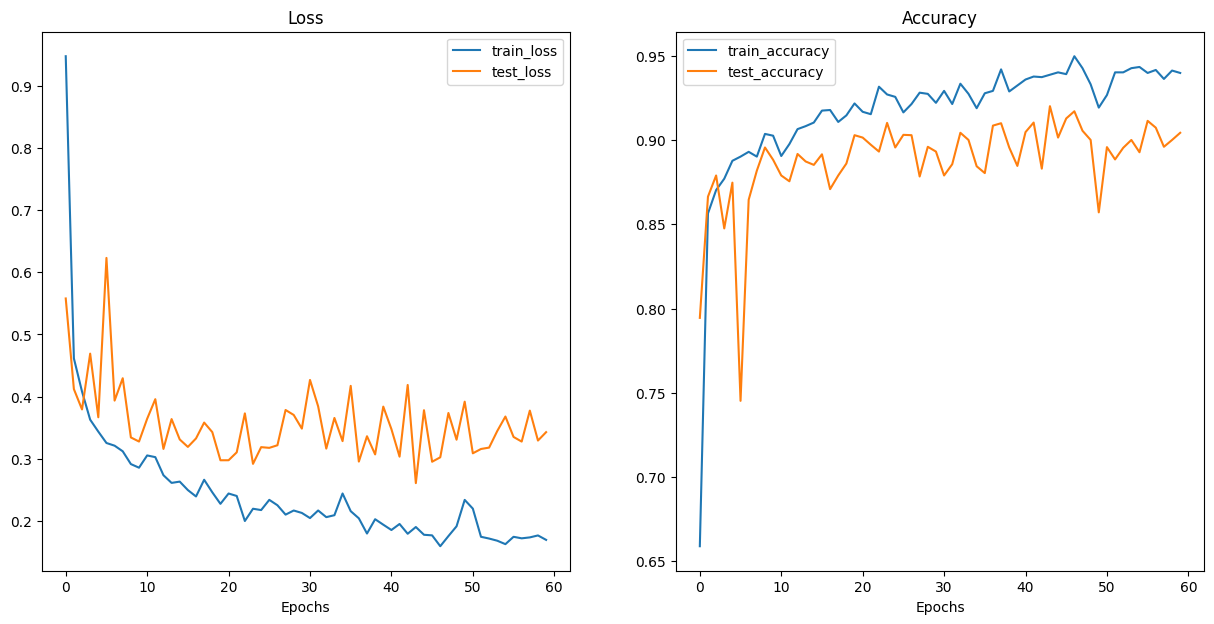

In [ ]:
from helper_functions import plot_loss_curves

# Plot our ViT model's loss curves
plot_loss_curves(results)

ValueError: The number of FixedLocator locations (7), usually from a call to set_ticks, does not match the number of labels (2).

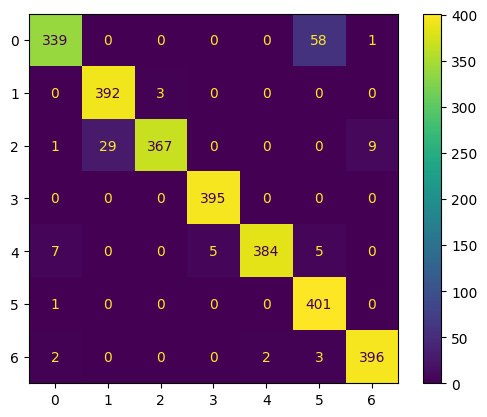

In [ ]:
import torch
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

# Assuming you have a Vision Transformer model defined
model = vit      #vit     pretrained_vit

# Assuming you have a DataLoader for the testing dataset
# test_loader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False)

# Set the model to evaluation mode
model.eval()

# Lists to store predictions and ground truth labels
all_predictions = []
all_labels = []

# Loop through the testing dataset
with torch.no_grad():
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(inputs)

        # Save predictions and labels for confusion matrix
        _, predicted = torch.max(outputs, 1)
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Convert lists to numpy arrays
all_predictions = np.array(all_predictions)
all_labels = np.array(all_labels)

# Generate confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)


# Display the confusion matrix
display = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=range(2))  # adjust the range as desire 2 or 7 or .....
display.plot()

# # Visualize the confusion matrix
# plt.figure(figsize=(8, 8))
# plot_confusion_matrix(conf_matrix, classes=[str(i) for i in range(conf_matrix.shape[0])], normalize=True, title='Confusion Matrix')
# plt.show()


Evaluating: 100%|██████████| 88/88 [00:22<00:00,  3.95batch/s]


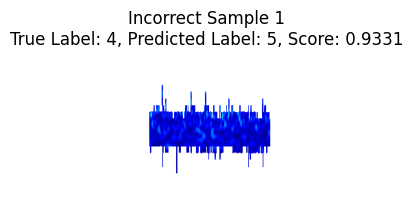

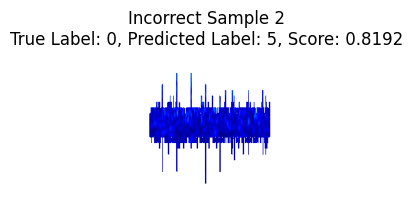

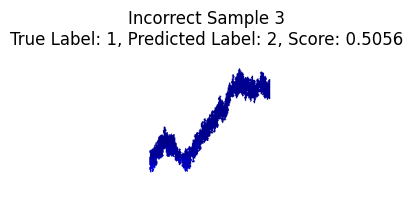

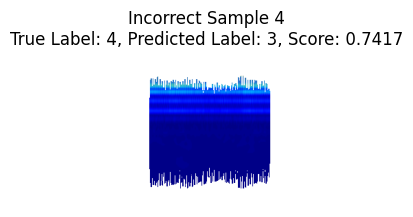

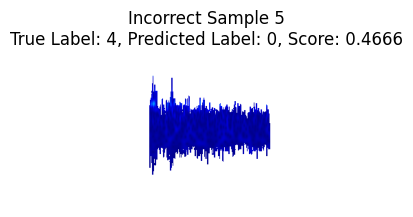

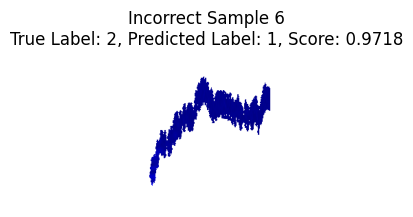

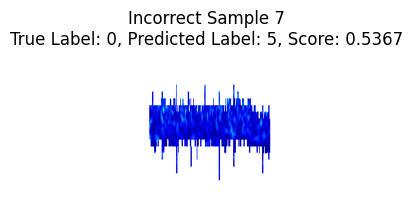

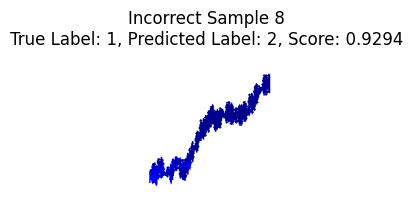

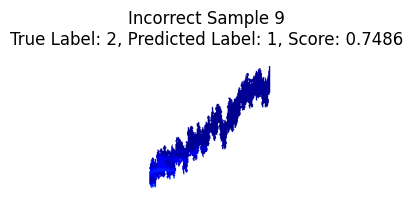

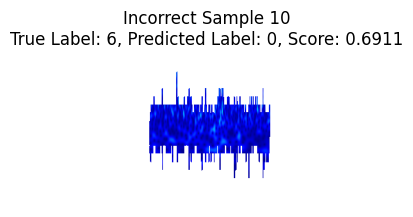

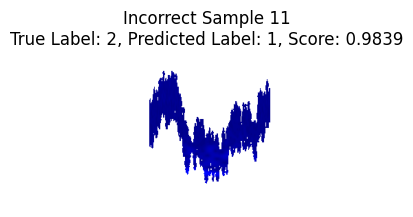

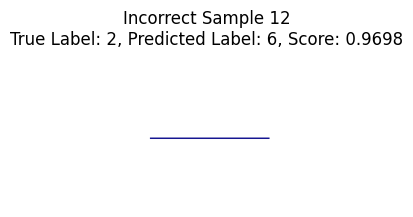

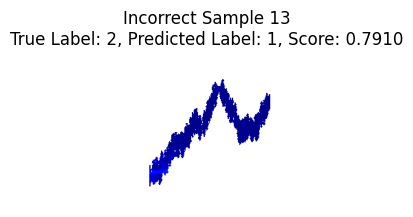

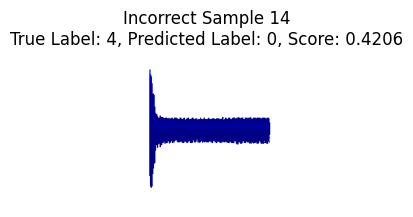

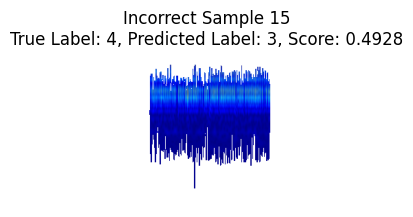

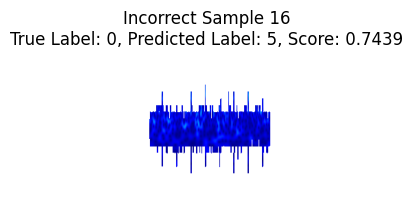

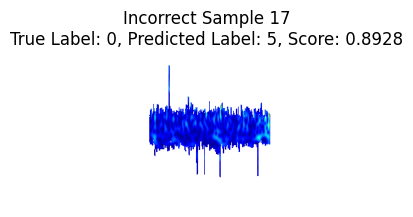

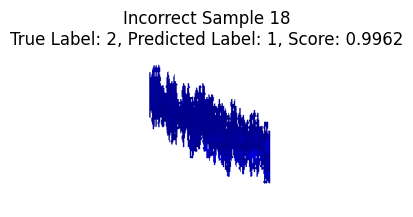

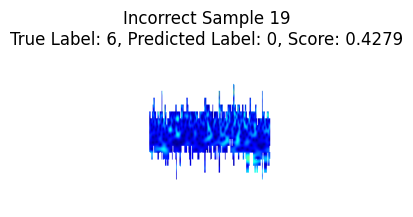

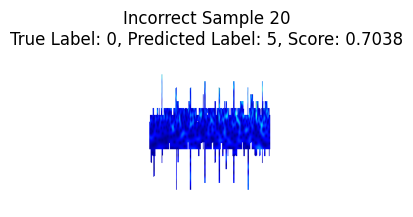

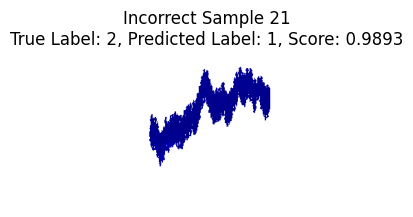

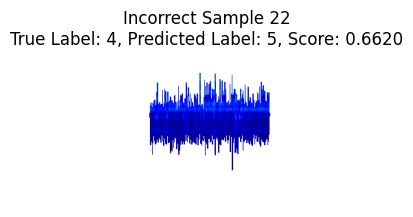

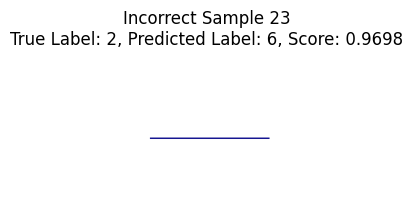

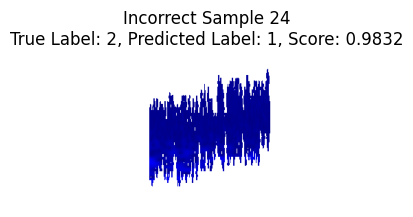

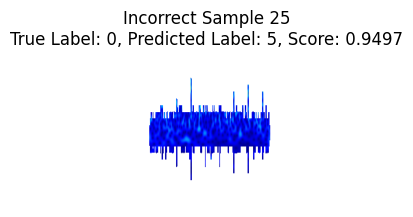

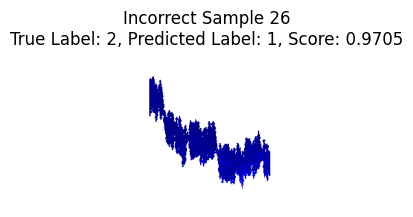

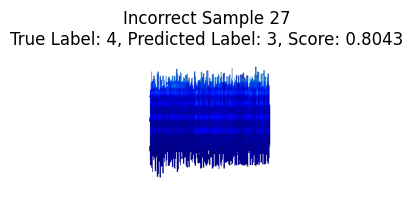

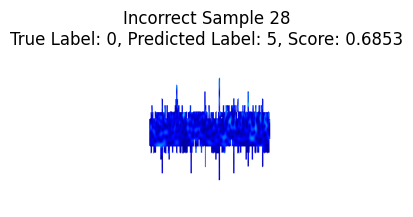

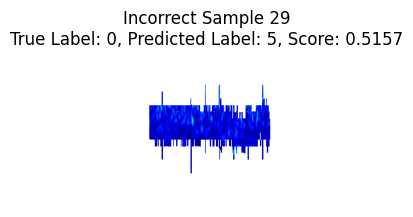

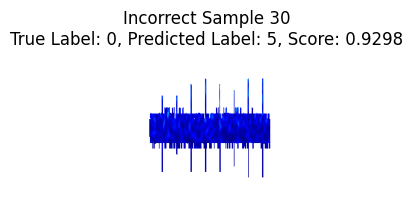

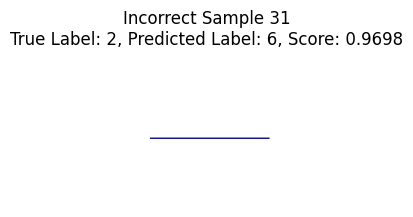

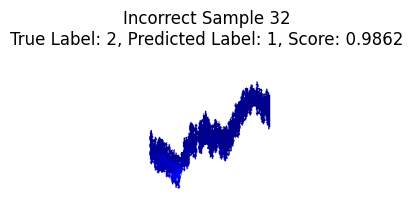

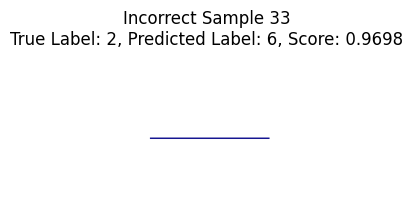

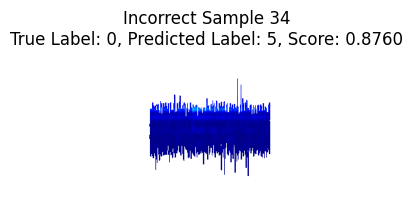

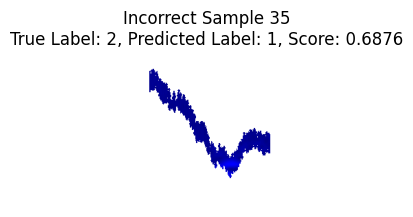

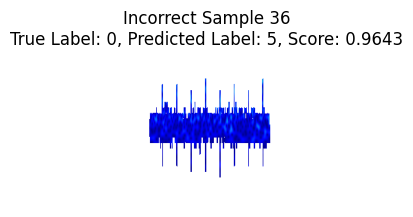

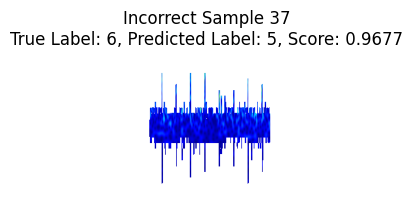

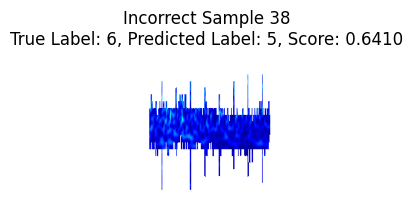

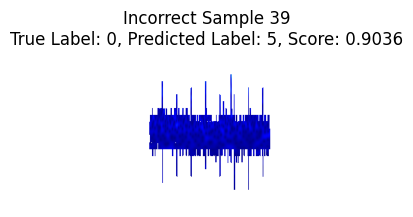

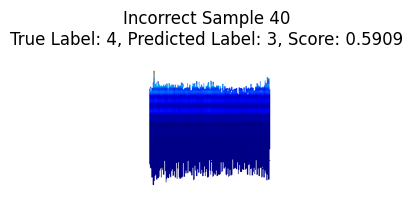

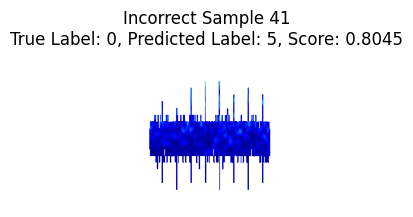

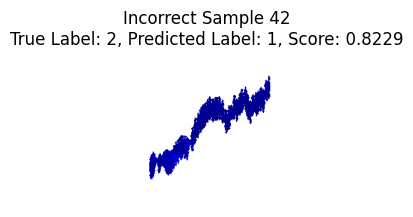

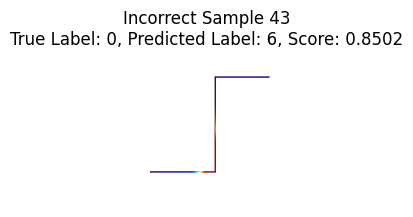

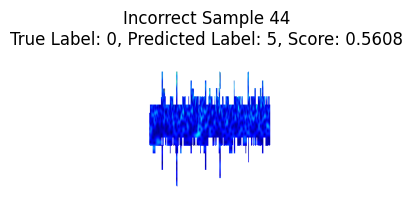

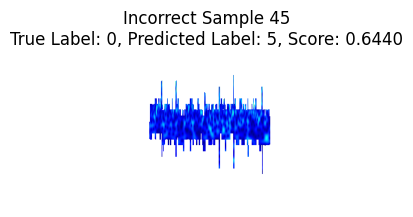

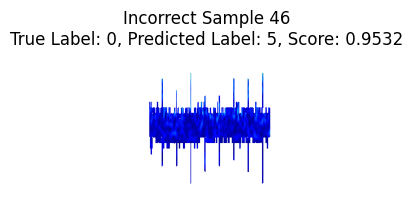

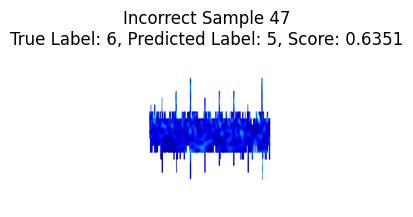

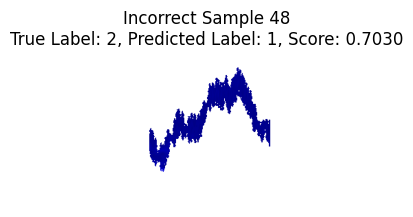

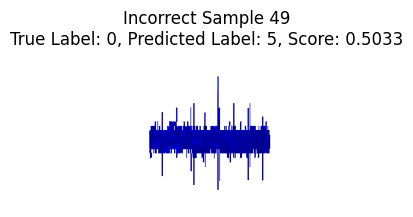

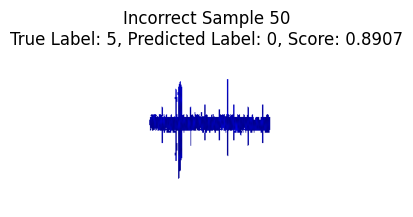

In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have a Vision Transformer model defined
model = vit

# Assuming you have a DataLoader for the testing dataset
# test_loader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False)

# Set the model to evaluation mode
model.eval()

# Lists to store true labels, predicted labels, confidence scores, and images for incorrect predictions
incorrect_true_labels = []
incorrect_predicted_labels = []
incorrect_scores = []
incorrect_images = []

# Loop through the testing dataset
with torch.no_grad():
    for inputs, labels in tqdm(train_loader, desc='Evaluating', unit='batch'):
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(inputs)

        # Get predicted labels and corresponding scores
        _, predicted = torch.max(outputs, 1)
        probabilities = torch.softmax(outputs, dim=1)
        confidence_scores, _ = torch.max(probabilities, 1)

        # Check if the prediction is incorrect
        incorrect_mask = predicted != labels

        # Append to lists for incorrect predictions
        incorrect_true_labels.extend(labels[incorrect_mask].cpu().numpy())
        incorrect_predicted_labels.extend(predicted[incorrect_mask].cpu().numpy())
        incorrect_scores.extend(confidence_scores[incorrect_mask].cpu().numpy())
        incorrect_images.extend(inputs[incorrect_mask].cpu().numpy())

# Convert lists to numpy arrays
incorrect_true_labels = np.array(incorrect_true_labels)
incorrect_predicted_labels = np.array(incorrect_predicted_labels)
incorrect_scores = np.array(incorrect_scores)
incorrect_images = np.array(incorrect_images)

# Visualize the incorrectly predicted samples
num_samples_to_visualize = min(50, len(incorrect_true_labels))

for i in range(num_samples_to_visualize):
    image_np = np.transpose(incorrect_images[i], (1, 2, 0))

    plt.figure(figsize=(6, 2))
    plt.imshow(image_np)
    plt.title(f"Incorrect Sample {i + 1}\nTrue Label: {incorrect_true_labels[i]}, Predicted Label: {incorrect_predicted_labels[i]}, Score: {incorrect_scores[i]:.4f}")
    plt.axis('off')
    plt.show()
